Generating Long Sequences with Sparse Transformers

https://arxiv.org/abs/1904.10509

https://github.com/openai/sparse_attention/blob/master/attention.py


#### Factorized Self-Attention
ここで説明するのは、Decoderのself-attentionで行うmask処理についてです。
sparse transformerでは図のように、self-attentionをいくつかのattentionのステップに分けます。一番左の通常のtransformerでのattentionはfull self-attention、ほかの2つはsparse transformerで使用されるattentionでありfactorized self-attentionと呼ぶこととします。

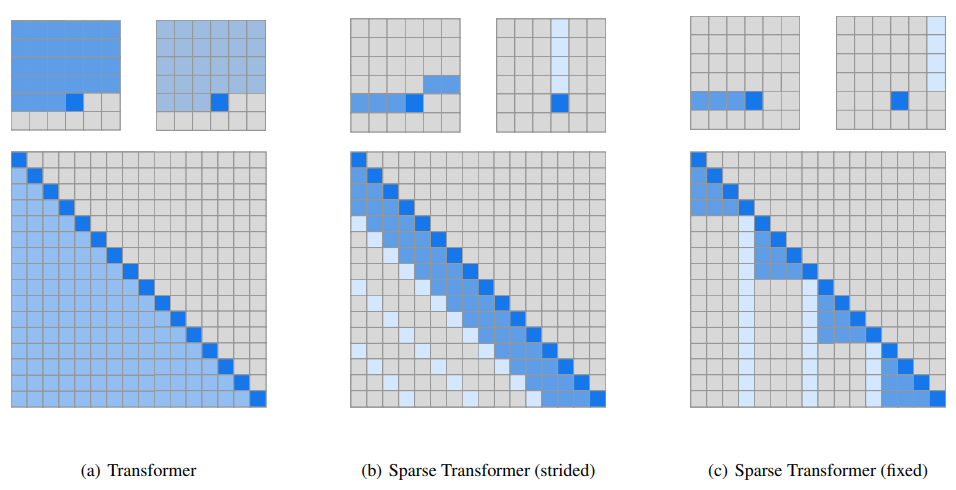


self-attention layerは、入力埋め込み$X$の行列を出力行列にマッピングし、接続パターン$S = {S_1, \cdots, S_n}$によってパラメータ化されます。ここで、$S_i$は$i$番目の出力ベクトルが注意を向ける入力ベクトルのインデックスのセットを表します。
出力ベクトルは、入力ベクトルの変換の加重和です。

$$
Attend(X,S)=\big(a(\boldsymbol{x}_i,S_i)\big)_{i\in\{1,\cdots,n\}}\\
a(\boldsymbol{x}_i,S_i)=softmax\bigg(\frac{(W_q\boldsymbol{x}_i)K_{S_i}^T}{\sqrt{d}} \bigg)V_{S_i}\\
K_{S_i}=(W_k\boldsymbol{x}_j)_{j\in S_i},\hspace{4mm}V_{S_i}=(W_v\boldsymbol{x}_j)_{j\in S_i}
$$

ここで、$W_q$、$W_k$、および$W_v$は、指定された$x_i$をquery、key、またはvalueに変換する重み行列を表し、$d$はクエリとキーの内部次元です。
各位置での出力は、keyとqueryのスケーリングされたドット積の類似性によって重み付けされたvalueの合計です。

full self-attentionでは、$Si = \{j : j \leq i\}$と定義して、すべての要素が自分より前のすべての位置と自分自身の位置に注意を向けることを可能にします。
factorized self-attentionには$p$個の個別のattention-headがあり、$m$番目のヘッドはインデックス$A_i^{(m)} \subset \{j : j \leq i\}$のサブセットを定義し、$Si = A_i^{(m)}$とします。ここで、$|A_i^{(m)}| \propto \sqrt[p]{n}$とします。

$A$の有効な選択を検討します。ここで、すべての入力位置は、attentionの$p$ステップ全体で将来のすべての出力位置に接続されます。
すべての$j \leq i$のペアについて、$i$が最大長$p + 1$のパスを介して$j$に注意できるように$A$を設定します。
具体的には、$(j, a, b, c, \cdots, i)$がインデックスのパスである場合、$j \in A_a^{(1)},a\in A_b^{(2)},b \in A_c^{(3)}$、などです。

2つのfactorized self-attentionによって計算量を$O(n\sqrt[p]{n})$に減らしながら、一定のステップ数で任意の入力位置から任意の出力位置に信号を伝搬するtransformerの能力を維持することができます。
次に$p = 2$の場合の2つの因数分解を調べますが、同じ手法をより高い次元に簡単に拡張できることに注意してください。

#### Two-dimensional factorized attention
2次元におけるfactorized attentionを定義する自然な方法としては、1つのheadを$l$前の位置まで注目させ、他方のheadを$l$ずつ前の位置を注目させていくことです。ここで、$l$はストライドで$\sqrt{n}$に近い値を選びます。これをstrided attentionと呼びます。

$$
A_i^{(1)}=\{t,t+1,\cdots,i\}\ for\ t=\max(0,i-l)\\
A_i^{(2)}=\{j:(i-j)\mod\ l=0\}
$$

この定式化は、画像やある種の音楽のように、ストライドに合わせた構造がデータにある場合に便利です。
ただし、テキストのように周期構造を持たないデータの場合、ネットワークがストライドを使用して情報を適切に取得できません。

そこで、fixed attentionを使用します。特定のセルが以前の場所を要約し、その情報を将来のすべてのセルに伝達します。

$$
A_i^{(1)}=\{j:([j/i]=[i/j])\}
$$

ここで$[・]$はフロア関数(整数部分を取得)を表します。

$$
A_i^{(2)}=\{j:j\mod l\in \{t,t+1,\cdots,l\} \}
$$

ここで、$t=l-c$であり、$c$はハイパーパラメータです。


#### Sparse Transformer
#####  Factorized attention heads
標準的なattentionでは、上で定義したattend関数の出力を線形変換します。

$$
attention(X)=W_p・attend(X,S)
$$

ここで、$W_p$は重み行列です。
因子分解されたself-attentionを統合するための最も簡単な方法としては、transformer blockごとに1つのattentionタイプを使用し、それらを順次またはハイパーパラメーターとして決定された比率で挟み込みます。

$$
attention(X)=W_p・attend(X,A^{(r\mod p)})
$$

ここで、$r$はtransformer blockのインデックスであり、$p$はfactorized attention headsの番号を表します。

2つ目のアプローチとして、factorized headsをまとめて1つのheadとするものです。これをmerged headと呼びます。

$$
attention(X)=W_p・attend(X,\cup_{m=1}^p A^{(m)} )
$$

3番目のアプローチは、multi-head-attentionを使うものです。
ここで、$n_h$個に分けて並列に計算し、結合するというものです。

$$
attention(X)=W_p\big(attend(X,A)^{i} \big)_{i\in (1,\cdots,n_h)}
$$

attend関数の中の重み行列の次元は$1/n_h$に縮小します。

#### Scaling to hundreds of layers

Transformerは多くのレイヤーでトレーニングするのが難しいことがわかっています。
auxillary損失を組み込む代わりに、以下のようなアーキテクチャの変更を採用しました。
まず、活性化前の残差ブロックを使用し、$N$層のネットワークを次のように定義します。

$$
H_0=embed(X,W_e)\\
H_k=H_{k-1}+resblock(H_{k-1})\\
y=softmax(norm(H_N)W_{out})
$$

ここで、$embed$は次のセクションで説明する関数、$W_{out}$は重み行列、$resblock(h)$はattentionブロックと位置ごとのフィードフォワードネットワークへの入力を次の方法で正規化します。


ノルム関数はレイヤーの正規化 (Ba et al.,2016) を表し、ff(x) = W2 f(W1x + b1) + b2 です。
f の選択は、(Rad ford et al., 2018) で使用されているように、Gaussian Error Linear Unit (Hendrycks & Gimpel, 2016)、f(X) = X sigmoid(1.702 · X) です。
特に指定のない限り、W1 の出力次元は入力次元の 4.0 倍です。
HN は関数 a と b の N 個の適用の合計であり、したがって各関数ブロックは出力層 から勾配を直接受け取ることに注意してください。
式 (1) の W2 と Wp の初期化をスケーリングします。 √12N で 5 を使用して、入力埋め込みスケールと残差ブロック スケールの比を N の値全体で不変に保ちます。

#### Modeling diverse data types
入力シンボルの埋め込みに加えて、位置埋め込みは通常、トランスフォーマーやその他の位置に依存しないアーキテクチャで使用され、データの空間的関係をエンコードします (Gehring et al., 2017)、(Parmar et al., 2018)。
データの構造または因数分解された注意パターンをエンコードする学習済み埋め込みを使用することが、モデルのパフォーマンスにとって重要であることがわかりました。
nemb = ddata または nemb = dattn 埋め込みを各入力位置に追加しました。ここで、ddata はデータの次元数を表し、dattn は因数分解された注意の次元数です。
xi がシーケンス内のワンホット エンコードされた i 番目の要素であり、o(j)i が j 次元 (1 ≤ j ≤ nemb) における xi のワンホット エンコードされた位置を表す場合、次のようになります。


画像の場合、データ埋め込みを使用しました。ここで、各入力バイトの行、列、およびチャネルの位置に ddata = 3 を指定します。
テキストとオーディオには、2 次元のアテンション埋め込みを使用しました。ここで、dattn = 2 であり、インデックスはストライドに等しい幅のマトリックス内の各位置の行と列のインデックスに対応します。

#### Saving memory by recomputing attention weights
勾配チェックポイントは、ディープ ニューラル ネットワークのトレーニングに必要なメモリを削減するのに効果的であることが示されています (Chen et al., 2016), (Gruslys et al., 2016)。
ただし、この手法は、長いシーケンスが処理されるときの自己注意層に特に効果的であることに注意してください。これらの層では、計算コストに比べてメモリ使用量が多いためです。
再計算のみを使用して、16,384 のシーケンス長で数百のレイヤーを使用して高密度の注意ネットワークをトレーニングできます。これは、そうでなければ最新のハードウェアでは実行不可能です。
私たちの実験では、後方パス中に注意ブロックとフィードフォワード ブロックを再計算します。
実装を簡素化するために、(Vaswani et al., 2017) のようにアテンション ブロック内にドロップアウトを適用せず、代わりに、図 4 に示すように、各残差追加の最後にのみ適用します。

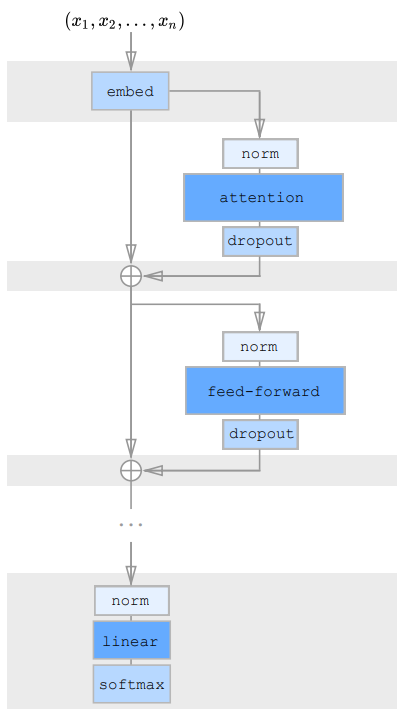

#### Efficient block-sparse attention kernels
3(b) と 3(c) のスパース Attention マスクは、クエリ、キー、および値の行列からサブブロックを切り出して、積をブロック単位で計算することにより、効率的に計算できます。
ローカル ウィンドウに対するアテンションはそのまま計算できますが、ストライド k のアテンションは、行列を転置してローカル ウィンドウを計算することで計算できます。
固定された注意位置は、ブロック単位で集計および計算できます。
実験を容易にするために、これらの操作を効率的に実行する一連の GPU カーネルを実装しました。
ソフトマックス操作は単一のカーネルに融合され、レジスターを使用して入力データを複数回ロードすることを排除し、単純な非線形性と同じ速度で実行できるようにします。
Attention 行列の上三角は計算されません。さらに、(Vaswani et al., 2017) の負のバイアス項の必要性がなくなり、実行される操作の数が半分になります。

### Training
5000 回の反復の線形ウォームアップと 1.0 の勾配クリッピングで Adam オプティマイザーを使用します。どちらもモデルの安定性にとって重要であることがわかりました。
0.01 の重量減衰ペナルティを使用します。
(Radford et al., 2018) のように、コサイン減衰に従って学習率をアニーリングしました。
特に明記しない限り、8 つの V100 GPU でトレーニングします。

すべての埋め込みは定数次元 d であり、通常は {256, 512, 1024} のいずれかです。
デフォルトでは、入力を 4d に射影するフィードフォワード ネットワークを除いて、すべての線形変換は同じ次元になります。 さらに、クエリとキー変換のサイズを半分にすることもあります。
トークン埋め込み We を N (0,0√.125d) から初期化し、位置埋め込みを N (0, √0.125dnemb) から初期化します。
Attention コンポーネントとフィードフォワード コンポーネント内では、すべてのバイアスが 0 に初期化され、すべての重みが N (0,0√.125din) から初期化されます。din はファンインの次元です。
出力ロジットの重み行列は 0 に初期化されました。

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Activation, Dropout, LayerNormalization, Reshape, Embedding, MultiHeadAttention
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt

In [2]:
class AddPositionalEncoding(Layer):
    '''
    入力テンソルに対し、位置の情報を付与して返すレイヤー
    see: https://arxiv.org/pdf/1706.03762.pdf

    PE_{pos, 2i}   = sin(pos / 10000^{2i / d_model})
    PE_{pos, 2i+1} = cos(pos / 10000^{2i / d_model})
    '''
    def call(self, inputs):
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

        # cos(x) == sin(x + π/2)
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

        pos_counter = tf.range(max_length)
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        # [batch_size, max_length, depth]
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

        return inputs + positional_encoding

In [3]:
class MultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        '''
        Multi-Head Attentionレイヤ
    
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : マルチヘッドAttentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''

        super(MultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
                   decoder:mask multihead attentionではq_length=m_length
                           2つ目のmultihead attentionではq_length≠m_length
        attention_mask : attention weight に適用される mask
            encoder : [1, 1, q_length, q_length]
            decoder : [1, 1, m_length, m_length]
        """
        # 各値を取得
        shape = query.shape.as_list() # batch_size, head_num, q_length, hidden_dim//head_num
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数(q_length)
        hidden_dim = shape[1]*shape[3] # 特徴ベクトルの長さ(head_num × hidden_dim//head_num = hidden_dim)
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [batch_size, head_num, q_length, hidden_dim/head_num] @ [batch_size, head_num, hidden_dim/head_num, m_length] = [batch_size, head_num, q_length, m_length]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [1, 1, (q|m)_length, (q|m)_length] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores, axis=-1)
        
        # 重みに従って value から情報を引いてきます
        # [batch_size, head_num, q_length, m_length] @ [batch_size, head_num, m_length, hidden_dim/head_num] = [batch_size, head_num, q_length, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = tf.transpose(context, [0, 2, 1, 3])
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim]
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, (q|m)_length, head_num, hidden_dim/head_num] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, (q|m)_length, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, (q|m)_length, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, q_length, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

In [4]:
class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        '''
        hidden_dim : Embeddingされた単語ベクトルの長さ
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='gelu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        x : 入力 [batch_size, length, hidden_dim]
        '''
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, (q|m)_length, 4*hidden_dim] -> [batch_size, (q|m)_length, hidden_dim]
        return self.output_dense_layer(x)

In [5]:
class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        '''
        layer : 残渣接続したいレイヤ(MultiHeadAttentionかFeedForwardNetwork)に適用
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        モデルの実行
        
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのlengthと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            # attention weightを返す
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            # attention weightを返さない
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

In [6]:
class EncoderLayer(Layer):
    """
    Encoderレイヤ
    　MultiHeadAttentionとFeedForwardNetworkの組み合わせ
      それぞれ残差接続されている
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # Multi-head attention
        self.atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim,
                                       heads_num = heads_num,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # Feed Forward Network
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

In [7]:
class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, q_length, hidden_dim]
        memory: 入力 [batch_size, m_length, hidden_dim]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, q_length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)

        # Encoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

In [8]:
class DecoderLayer(Layer):
    """
    3つのsub-layerを持つ
    decoder layer : before ->[mask attention -> enc attention -> FF]-> next
    mask attentionは未来の情報を参照しないためのマスクを適用
    enc attentionはencoderの出力をkey, valueとする。
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # mask self-attention : mask処理を行う
        self.mask_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # attention : encoderの出力をmemory(key,value)として受け取る
        self.enc_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        if return_attention_scores:
            x, dec_attn_weights = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=return_attention_scores)
            x, encdec_attn_weights = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=return_attention_scores)
            x = self.ffn(x)
            return x, dec_attn_weights, encdec_attn_weights
        else:
            x = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=False)
            x = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=False)
            x = self.ffn(x)
            return x

In [9]:
class Decoder(Layer):
    '''
    TransformerのDecoder
    '''
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [DecoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        # Decoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, dec_attn_weights, encdec_attn_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)
            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), dec_attn_weights, encdec_attn_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

In [10]:
class SparseTransformerTimeSeriesForecastModel(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate, local_attn_ctx=2):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.local_attn_ctx = local_attn_ctx
        self.heads_num = heads_num
        
        self.encoder = Encoder(hopping_num, heads_num, hidden_dim, drop_rate)
        self.decoder = Decoder(hopping_num, heads_num, hidden_dim, drop_rate)
        
        # 全結合層
        self.fc = Dense(8)
        self.dropout = Dropout(drop_rate)
        self.final_layer = Dense(1)

    def call(self, inputs, training, return_attention_scores=False):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        enc_input, dec_input = inputs
        
        local_mask = self._create_factorized_mask(dec_input, 'local', self.local_attn_ctx)
        strided_mask = self._create_factorized_mask(dec_input, 'strided', self.local_attn_ctx)
        
        #self_attention_mask=self._create_look_ahead_mask(dec_input)
        self_attention_mask=tf.concat([local_mask if m%2 else strided_mask for m in range(self.heads_num)], axis=1)
        
       # Encoderの出力はDecoderへの入力(memory)となる
        # enc_input : [batch_size, enc_length, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        
        # dec_input : [batch_size, dec_length, hidden_dim]
        # dec_output : [batch_size, dec_length, hidden_dim]
        # dec_attn_weights : [batch_size, dec_length, dec_length]
        # encdec_attn_weights : [batch_size, dec_length, enc_length]
        if return_attention_scores:
            dec_output, dec_attn_weights, encdec_attn_weights = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
        else:
            dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
       
        
        # [batch_size, dec_length, hidden_dim] -> [batch_size, dec_length]
        fc_output = self.fc(dec_output)
        fc_output = self.dropout(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights, dec_attn_weights, encdec_attn_weights
        else:
            return final_output
    
    def _create_look_ahead_mask(self, x):
        batch_size, length, _ = x.shape
        autoregression_array = tf.logical_not(tf.linalg.band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
        autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])
        return tf.cast(autoregression_array, dtype=tf.float32)
    
    def _create_factorized_mask(self, x_dec, attn_mode, local_attn_ctx=None):
        batch_size, n, _ = x_dec.shape
        if attn_mode == 'all':
            b = tf.linalg.band_part(tf.ones([n, n]), -1, 0)
        elif attn_mode == 'local':
            bandwidth = local_attn_ctx
            ctx = tf.minimum(n - 1, bandwidth - 1)
            b = tf.linalg.band_part(tf.ones([n, n]), ctx, 0)
        elif attn_mode == 'strided':
            stride = local_attn_ctx
            x = tf.reshape(tf.range(n, dtype=tf.int32), [n, 1])
            y = tf.transpose(x)
            z = tf.zeros([n, n], dtype=tf.int32)
            q = z + x
            k = z + y
            c1 = q >= k
            c2 = tf.equal(tf.math.floormod(q - k, stride), 0)
            c3 = tf.logical_and(c1, c2)
            b = tf.cast(c3, tf.float32)
        else:
            raise ValueError('Not yet implemented')
        b = tf.reshape(b, [1, 1, n, n])

        return 1-b

In [11]:
class minmaxscaling:
    def __init__(self,max_value, min_value, upl=0, downl=0):
        self.max = max_value + max_value*upl
        self.min = min_value - min_value*downl
    
    def translate(self, x):
        return (x - self.min) / (self.max - self.min)

def make_ts_data(window_width, dmodel, pred_points, split_point):
    data = pd.read_csv('ilidata.csv')
    data = np.array(data[['WEIGHTED_ILI']])

    scaler = minmaxscaling(8, 0, 0.1)
    data = scaler.translate(data).ravel()

    train_data = data[:split_point]
    test_data = data[split_point-dmodel:570]

    train_emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])
    test_emb_data = np.array([test_data[i:i+dmodel] for i in range(len(test_data)-dmodel)])

    enc_train = np.array([train_emb_data[i:i+window_width] for i in range(len(train_emb_data)-window_width-pred_points)])
    dec_train = np.array([train_emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(train_emb_data)-window_width-pred_points)])
    y_train = np.array([train_emb_data[i+window_width:i+window_width+pred_points] for i in range(len(train_emb_data)-window_width-pred_points)])

    enc_test = np.array([test_emb_data[i:i+window_width] for i in range(len(test_emb_data)-window_width-pred_points)])
    dec_test = np.array([test_emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(test_emb_data)-window_width-pred_points)])
    y_test = np.array([test_emb_data[i+window_width:i+window_width+pred_points] for i in range(len(test_emb_data)-window_width-pred_points)])

    enc_train = tf.constant(enc_train)
    enc_test = tf.constant(enc_test)
    dec_train = tf.constant(dec_train)
    dec_test = tf.constant(dec_test)
    y_train = tf.constant(y_train)
    y_test = tf.constant(y_test)

    print('encinput_train ', enc_train.shape)
    print('decinput_train ', dec_train.shape)
    print('y_train ', y_train.shape)

    print('encinput_test ', enc_test.shape)
    print('decinput_test ', dec_test.shape)
    print('y_test ', y_test.shape)
    return enc_train, dec_train, y_train, enc_test, dec_test, y_test

window_width = 10 # 予測に使う点数
dmodel = 8 # embeddingの次元
pred_points = 4 # 予測する点数
split_point = 515 # trainとtestを分ける点
enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

#plt.plot(np.arange(split_point), train_data);
#plt.plot(np.arange(split_point-dmodel,570), test_data)
#plt.xlim(0,600);

encinput_train  (493, 10, 8)
decinput_train  (493, 4, 8)
y_train  (493, 4, 8)
encinput_test  (41, 10, 8)
decinput_test  (41, 4, 8)
y_test  (41, 4, 8)


In [12]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = SparseTransformerTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=2, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [13]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
62/62 - 11s - loss: 1.1227 - mse: 1.1227 - lr: 0.0000e+00 - 11s/epoch - 184ms/step
Epoch 2/200
62/62 - 1s - loss: 1.1277 - mse: 1.1277 - lr: 8.0000e-06 - 693ms/epoch - 11ms/step
Epoch 3/200
62/62 - 1s - loss: 1.1217 - mse: 1.1217 - lr: 1.6000e-05 - 698ms/epoch - 11ms/step
Epoch 4/200
62/62 - 1s - loss: 0.9739 - mse: 0.9739 - lr: 2.4000e-05 - 698ms/epoch - 11ms/step
Epoch 5/200
62/62 - 1s - loss: 1.0000 - mse: 1.0000 - lr: 3.2000e-05 - 700ms/epoch - 11ms/step
Epoch 6/200
62/62 - 1s - loss: 0.8808 - mse: 0.8808 - lr: 4.0000e-05 - 712ms/epoch - 11ms/step
Epoch 7/200
62/62 - 1s - loss: 0.7208 - mse: 0.7208 - lr: 4.8000e-05 - 707ms/epoch - 11ms/step
Epoch 8/200
62/62 - 1s - loss: 0.7134 - mse: 0.7134 - lr: 5.6000e-05 - 724ms/epoch - 12ms/step
Epoch 9/200
62/62 - 1s - loss: 0.5994 - mse: 0.5994 - lr: 6.4000e-05 - 726ms/epoch - 12ms/step
Epoch 10/200
62/62 - 1s - loss: 0.5058 - mse: 0.5058 - lr: 7.2000e-05 - 726ms/epoch - 12ms/step
Epoch 11/200
62/62 - 1s - loss: 0.3978 - mse: 0.3

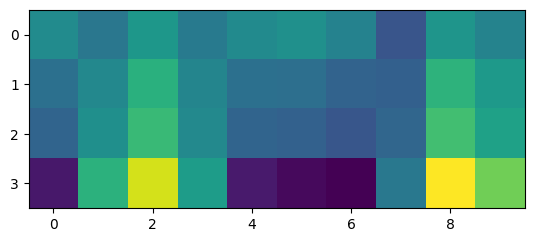

In [14]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [15]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

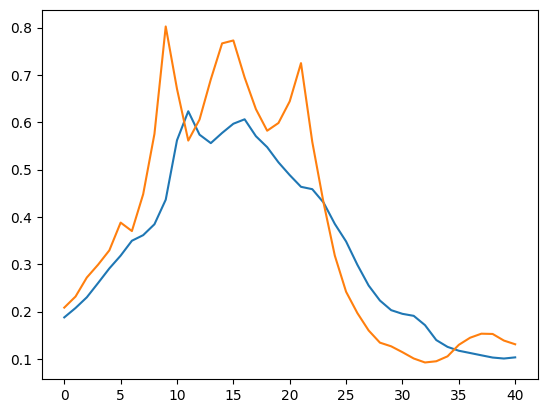

In [16]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,0,-1]);

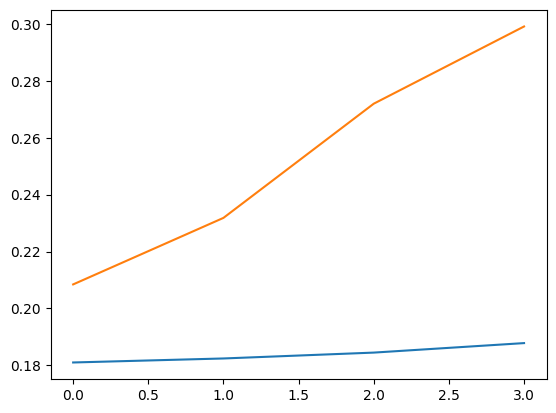

In [17]:
plt.plot(pred_results[0,0])
plt.plot(y_test[0,:,-1]);

In [18]:
window_width = 10
dmodel = 16
pred_points = 8

enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

encinput_train  (481, 10, 16)
decinput_train  (481, 8, 16)
y_train  (481, 8, 16)
encinput_test  (37, 10, 16)
decinput_test  (37, 8, 16)
y_test  (37, 8, 16)


In [19]:
model = SparseTransformerTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=2, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [20]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
61/61 - 10s - loss: 3.3487 - mse: 3.3487 - lr: 0.0000e+00 - 10s/epoch - 172ms/step
Epoch 2/200
61/61 - 1s - loss: 3.4033 - mse: 3.4033 - lr: 1.1314e-05 - 872ms/epoch - 14ms/step
Epoch 3/200
61/61 - 1s - loss: 3.0799 - mse: 3.0799 - lr: 2.2627e-05 - 877ms/epoch - 14ms/step
Epoch 4/200
61/61 - 1s - loss: 2.8183 - mse: 2.8183 - lr: 3.3941e-05 - 863ms/epoch - 14ms/step
Epoch 5/200
61/61 - 1s - loss: 2.3966 - mse: 2.3966 - lr: 4.5255e-05 - 868ms/epoch - 14ms/step
Epoch 6/200
61/61 - 1s - loss: 1.9289 - mse: 1.9289 - lr: 5.6569e-05 - 870ms/epoch - 14ms/step
Epoch 7/200
61/61 - 1s - loss: 1.6235 - mse: 1.6235 - lr: 6.7882e-05 - 865ms/epoch - 14ms/step
Epoch 8/200
61/61 - 1s - loss: 1.3505 - mse: 1.3505 - lr: 7.9196e-05 - 880ms/epoch - 14ms/step
Epoch 9/200
61/61 - 1s - loss: 1.1291 - mse: 1.1291 - lr: 9.0510e-05 - 868ms/epoch - 14ms/step
Epoch 10/200
61/61 - 1s - loss: 0.9060 - mse: 0.9060 - lr: 1.0182e-04 - 873ms/epoch - 14ms/step
Epoch 11/200
61/61 - 1s - loss: 0.7094 - mse: 0.7

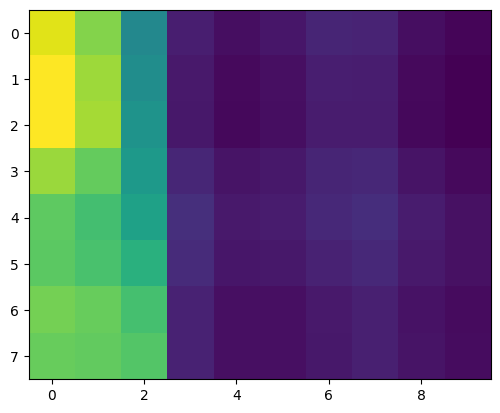

In [21]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [22]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

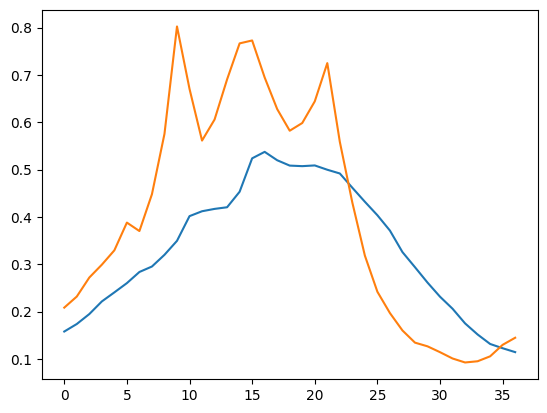

In [23]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,0,-1]);

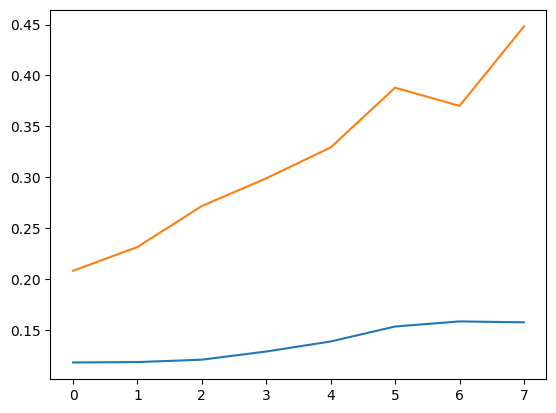

In [24]:
plt.plot(pred_results[0,0])
plt.plot(y_test[0,:,-1]);

In [25]:
window_width = 20
dmodel = 24
pred_points = 16

enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

encinput_train  (455, 20, 24)
decinput_train  (455, 16, 24)
y_train  (455, 16, 24)
encinput_test  (19, 20, 24)
decinput_test  (19, 16, 24)
y_test  (19, 16, 24)


In [26]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = SparseTransformerTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2,
            local_attn_ctx=3)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [27]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
57/57 - 12s - loss: 4.8353 - mse: 4.8353 - lr: 0.0000e+00 - 12s/epoch - 219ms/step
Epoch 2/200
57/57 - 2s - loss: 4.4935 - mse: 4.4935 - lr: 1.3856e-05 - 2s/epoch - 30ms/step
Epoch 3/200
57/57 - 2s - loss: 3.9483 - mse: 3.9483 - lr: 2.7713e-05 - 2s/epoch - 30ms/step
Epoch 4/200
57/57 - 2s - loss: 3.2093 - mse: 3.2093 - lr: 4.1569e-05 - 2s/epoch - 31ms/step
Epoch 5/200
57/57 - 2s - loss: 2.3485 - mse: 2.3485 - lr: 5.5426e-05 - 2s/epoch - 29ms/step
Epoch 6/200
57/57 - 2s - loss: 1.7053 - mse: 1.7053 - lr: 6.9282e-05 - 2s/epoch - 30ms/step
Epoch 7/200
57/57 - 2s - loss: 1.2098 - mse: 1.2098 - lr: 8.3138e-05 - 2s/epoch - 29ms/step
Epoch 8/200
57/57 - 2s - loss: 0.9138 - mse: 0.9138 - lr: 9.6995e-05 - 2s/epoch - 31ms/step
Epoch 9/200
57/57 - 2s - loss: 0.7001 - mse: 0.7001 - lr: 1.1085e-04 - 2s/epoch - 30ms/step
Epoch 10/200
57/57 - 2s - loss: 0.5225 - mse: 0.5225 - lr: 1.2471e-04 - 2s/epoch - 30ms/step
Epoch 11/200
57/57 - 2s - loss: 0.4150 - mse: 0.4150 - lr: 1.3856e-04 - 2s/e

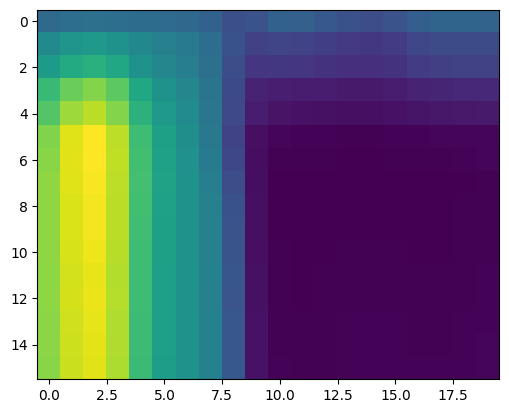

In [28]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [29]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

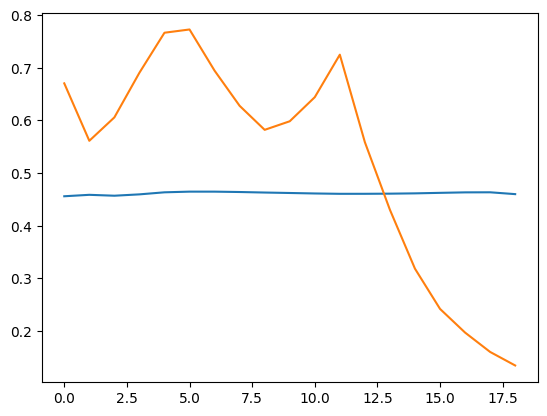

In [30]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,0,-1]);

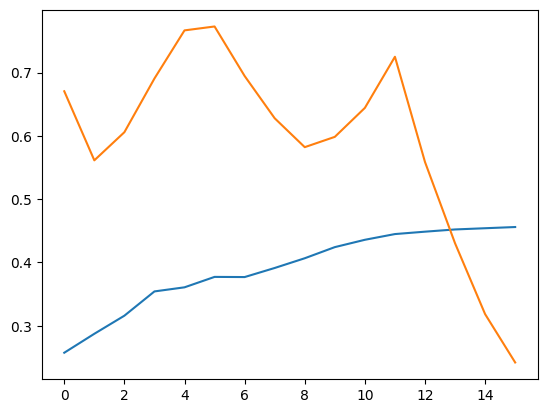

In [31]:
plt.plot(pred_results[0,0])
plt.plot(y_test[0,:,-1]);